# Specfem2D Workstation Examples

SeisFlows comes with some __Specfem2D synthetic examples__ to showcase the software in action. These examples are meant to be run on a __local machine__ (tested on a Linux workstation running CentOS 7, and an Apple Laptop running macOS 10.14.6).

The numerical solver we will use is: [SPECFEM2D](https://geodynamics.org/cig/software/specfem2d/). We'll also be working in our `seisflows` [Conda](https://docs.conda.io/en/latest/) environment, see the installation section on the home page for instructions on how to install and activate the required Conda environment. 

-----------------------------------

In [1]:
from IPython.display import Image  # Used to display .png files in the notebook/docs

## Example \#1: Homogenous Halfspace Inversion
Example \#1 runs a 1-iteration synthetic inversion with 1 event and 1 station, used to illustrate misfit kernels and updated models in adjoint tomography.

The starting/initial model (*MODEL_INIT*) and target/true model (*MODEL_TRUE*) are used to generate synthetics and (synthetic) data, respectively. Both models are homogeneous halfspace models defined by velocity (Vp, Vs) and density ($\rho$) with slightly varying P- and S-wave velocity values (**INIT**: $V_p$=5.8km/s, $V_s$=3.5km/s; **TRUE**: $V_p$=5.9km/s, $V_s$=3.55km/s). Only Vp and Vs are updated during the example.

Misfit during Example \#1 is defined by a 'traveltime' misfit using the `Default` preprocessing module. It also uses a `gradient-descent` optimization algorithm paired with a bracketing line search. No smoothing/regularization is applied to the gradient.

In [2]:
! seisflows examples 1  # print example help dialogue

No existing SPECFEM2D repo given, default to: /home/bchow/REPOSITORIES/seisflows/docs/notebooks/specfem2d

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                            @

### Running the example

You can either setup and run the example in separate tasks using the `seisflows examples setup` and `seisflows submit` commands, or by directly running the example after setup using the `examples run` command (illustrated below). 

Use the `-r` or `--specfem2d_repo` flag to point SeisFlows at an existing SPECFEM2D/ repository (with compiled binaries) if available. If not given, SeisFlows will automatically download, configure and compile SPECFEM2D in your current working directory.

In [ ]:
# Run command with open variable to set SPECFEM2D path
! seisflows examples setup 1 -r ${PATH_TO_SPECFEM2D}
! seisflows submit

# The following command is the same as above
! seisflows examples run 1 --specfem2d_repo ${PATH_TO_SPECFEM2D}

#### Running with MPI

If you have compiled SPECFEM2D with MPI, and have MPI installed and loaded on your system, you can run this example with MPI. To do so, you only need use the `--with_mpi` flag. By default SeisFlows will use only 1 core, but you can choose the number of processors/tasks with the `--nproc ${NPROC}` flag. The example call runs example 1 with 4 cores.

In [ ]:
# Run Solver tasks with MPI on 4 cores
! seisflows examples run 1 -r ${PATH_TO_SPECFEM2D} --with_mpi --nproc 4

By default the example problems assume that your MPI executable is `mpirun`. If for any reason `mpirun` is not what your system uses to call MPI, you can use the `--mpiexec ${MPIEXEC}` flag to change that.

In [ ]:
! seisflows examples run 1 -r ${PATH_TO_SPECFEM2D} --with_mpi --nproc 4 --mpiexec srun

We will not run the example in this notebook, however at this stage the User should run one of the following commands above to execute the example problem. A successfully completed example problem will end with the following log messages:

In [3]:
%cd ~/sfexamples/example_1
! ls

/home/bchow/Work/work/seisflows_example/example_1
logs	parameters.yaml  sflog.txt    specfem2d
output	scratch		 sfstate.txt  specfem2d_workdir


### Understanding example outputs

In the `output/` directory, we can see our starting/initial model (*MODEL_INIT*), our true/target model (*MODEL_TRUE*) and the updated model from the first iteration (*MODEL_01*). In addition, we have saved the gradient generated during the first iteration (*GRADIENT_01*) because we set the parameter `export_gradient` to True.

In [7]:
# The output directory contains important files exported during a workflow
! ls output

GRADIENT_01  MODEL_01  MODEL_INIT  MODEL_TRUE


In [9]:
# A MODEL output directory contains model files in the chosen solver format. 
# In this case, Fortran Binary from SPECFEM2D
! ls output/MODEL_01

proc000000_vp.bin  proc000000_vs.bin


### Plotting results

We can plot the model and gradient files created during our workflow using the `seisflows plot2d` command. The `--savefig` flag allows us to save output .png files to disk. The following figure shows the starting/initial homogeneous halfspace model in Vs.

Figure(707.107x707.107)


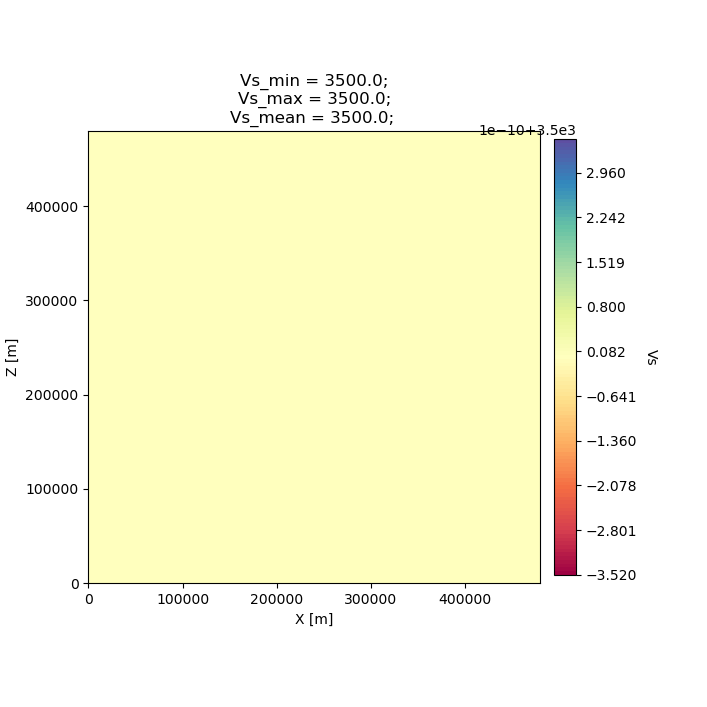

In [7]:
# Plot and open the initial homogeneous halfspace model
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image(filename='m_init_vs.png') 

We can also plot the gradient that was created during the adjoint simulation. In this example we only have one source and one receiver, so the gradient shows a "banana-doughnut" style kernel, representing volumetric sensitivity of the measurement (waveform misfit) to changes in model values.

Figure(707.107x707.107)


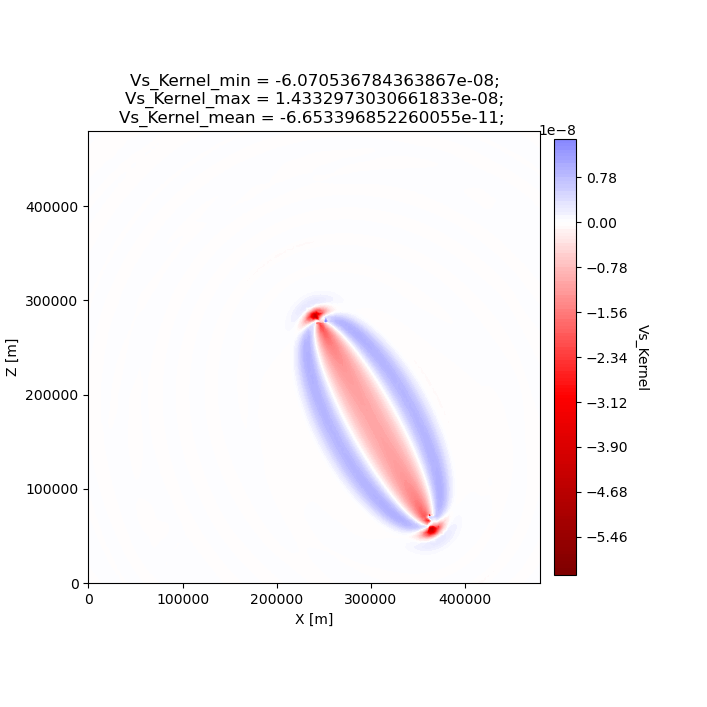

In [9]:
! seisflows plot2d GRADIENT_01 vs_kernel --savefig g_01_vs.png
Image(filename='g_01_vs.png') 

Finally we can plot the updated model (*MODEL_01*), which is the sum of the initial model and a scaled gradient. The gradient was scaled during the line search, where we used a steepest-descent algorithm to reduce the misfit between data and synthetics. Since we only have one source-receiver pair in this workflow, the updated model shown below almost exactly mimics the Vs kernel shown above.

Figure(707.107x707.107)


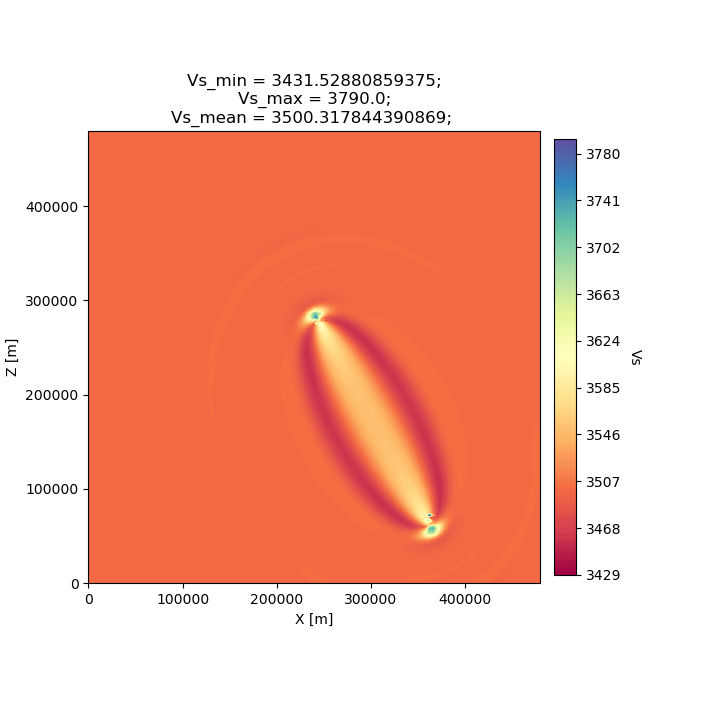

In [10]:
! seisflows plot2d MODEL_01 vs --savefig m_01_vs.png
Image(filename='m_01_vs.png') 

### Closing thoughts

In [ ]:
# An example call for running Example 1 with variable number of stations, events and iterations
! seisflows examples run 1 --nsta 10 --ntask 5 --niter 2

## Example \#2: Checkerboard Inversion (w/ Pyaflowa \& L-BFGS)

Building on the foundation of the previous example, Example \#2 runs a 2 iteration inversion with misfit quantification taken care of by the `Pyaflowa` preprocessing module, which uses the misfit quantification package [Pyatoa](https://github.com/adjtomo/pyatoa) under the hood. 

Model updates are performed using an [L-BFGS nonlinear optimization algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS). Example \#2 also includes smoothing/regularization of the gradient. This example more closely mimics a research-grade inversion problem.

In [10]:
# Run the help message dialogue to see what Example 2 will do
! seisflows examples 2

No existing SPECFEM2D repo given, default to: /home/bchow/Work/work/seisflows_example/example_1/specfem2d

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                            @

### Run the example 

You can run the example with the same command as shown for Example 1. Users following along will need to provide a path to their own installation of SPECFEM2D using the `-r` flag.

In [ ]:
! seisflows examples run 2 -r ${PATH_TO_SPECFEM2D}

### Understanding example outputs

As with Example \#1, we can look at the output gradients and models to visualize what just happenend under the hood. Be sure to read through the output log messages as well, to get a better idea of what steps and tasks were performed to generate these outputs.

In [15]:
%cd ~/sfexamples/example_2
! ls

/home/bchow/Work/work/seisflows_example/example_2
logs	parameters.yaml  sflog.txt    specfem2d
output	scratch		 sfstate.txt  specfem2d_workdir


Running the `plot2d` command without any arguments is a useful way to determine what model/gradient files are available for plotting. 

In [16]:
! seisflows plot2d

                                     PLOT2D                                     
                                     //////                                     
Available models/gradients/kernels

GRADIENT_01
GRADIENT_02
MODEL_01
MODEL_02
MODEL_INIT
MODEL_TRUE


Similarly, running `plot2d` with 1 argument will help determine what quantities are available to plot

In [17]:
! seisflows plot2d MODEL_TRUE

Traceback (most recent call last):
  File "/home/bchow/miniconda3/envs/docs/bin/seisflows", line 33, in <module>
    sys.exit(load_entry_point('seisflows', 'console_scripts', 'seisflows')())
  File "/home/bchow/REPOSITORIES/seisflows/seisflows/seisflows.py", line 1383, in main
    sf()
  File "/home/bchow/REPOSITORIES/seisflows/seisflows/seisflows.py", line 438, in __call__
    getattr(self, self._args.command)(**vars(self._args))
  File "/home/bchow/REPOSITORIES/seisflows/seisflows/seisflows.py", line 1106, in plot2d
    save=savefig)
  File "/home/bchow/REPOSITORIES/seisflows/seisflows/tools/specfem.py", line 428, in plot2d
    f"chosen `parameter` must be in {self._parameters}"
AssertionError: chosen `parameter` must be in ['vp', 'vs']


### Visualizing Initial and Target models

The starting model for this example is the same homogeneous halfspace model shown in Example \#1, with $V_p$=5.8km/s and $V_s$=3.5km/s. 

For this example, however, the target model is a checkerboard model with fast and slow perturbations roughly equal to $\pm10\%$ of the initial model. We can plot the model below to get a visual representation of these perturbations, where **red==slow** and **blue==fast**.

Figure(707.107x707.107)


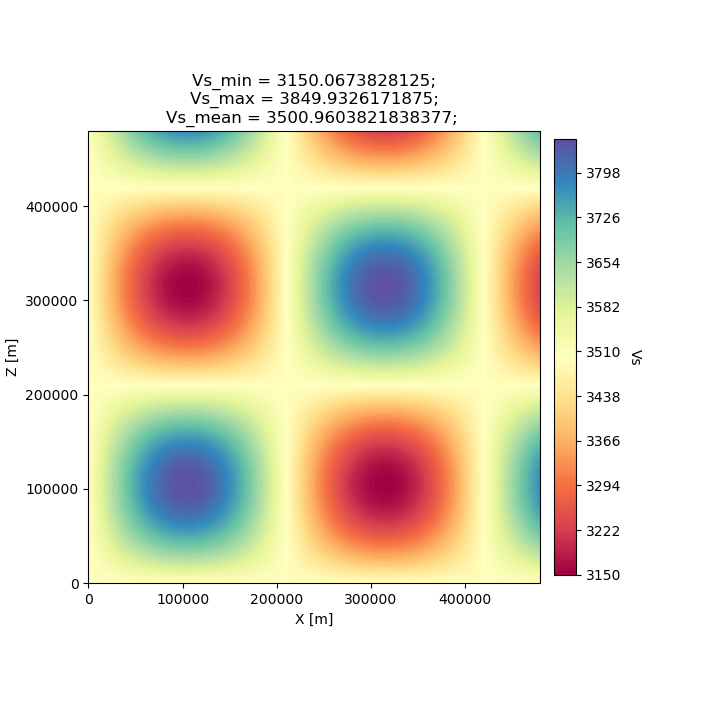

In [9]:
! seisflows plot2d MODEL_TRUE vs --savefig m_true_vs.png
Image(filename='m_true_vs.png') 

### Visualizing the Gradient

We can look at the gradients created during the adjoint simulations to get an idea of how our inversion wanted to update the model. Gradients tell us how to perturb our starting model (the homogeneous halfspace) to best fit the data that was generated by our target model (the checkerboard).

We can see that our gradient (Vs kernel) is characterized by large red and blue blobs. The blue colors in the kernel tell us that the initial model is too fast, while red colors tell us that the initial model is too slow (that is, **red==too slow** and **blue==too fast**). This makes sense if we look at the checkerboard target model above, where the perturbation is slow (red color) the corresponding kernel tells us the initial (homogeneous halfspace) model is too fast (blue color).

Figure(707.107x707.107)


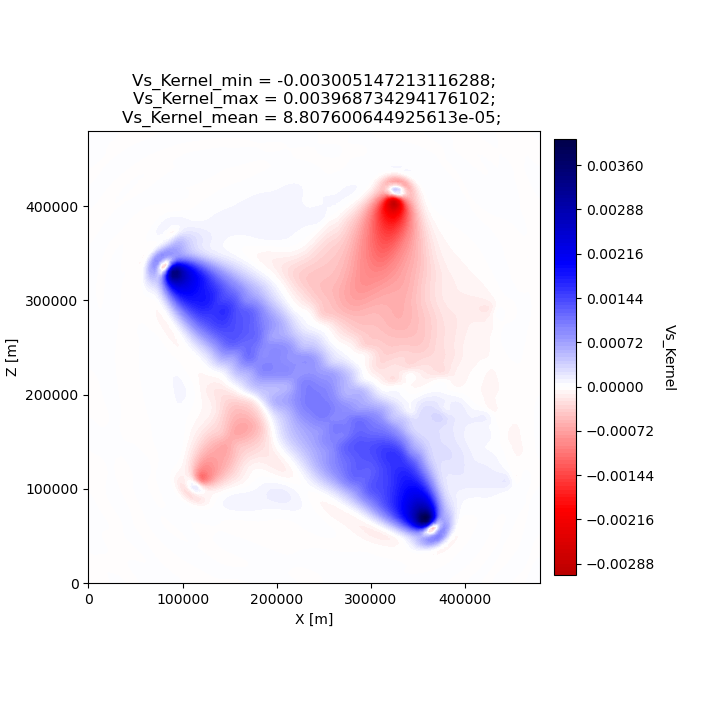

In [18]:
! seisflows plot2d GRADIENT_01 vs_kernel --savefig g_01_vs.png
Image(filename='g_01_vs.png') 

### Visualizing the updated model

After two iterations, the updated model starts to take form. We can clearly see that the lack of data coverage on the outer edges of the model mean we do not see any appreciable update here, whereas the center of the domain shows the strongest model updates which are starting to resemble the checkerboard pattern shown in the target model.

With only 4 events and 2 iterations, we do not have quite enough constraint to recover the sharp contrasts between checkers shown in the Target model. We can see that data coverage, smearing and regularization leads to more prominent slow (red) regions. 

If we were to increase the number of events and iterations, will it help our recovery of the target model? This task is left up to the reader!

Figure(707.107x707.107)


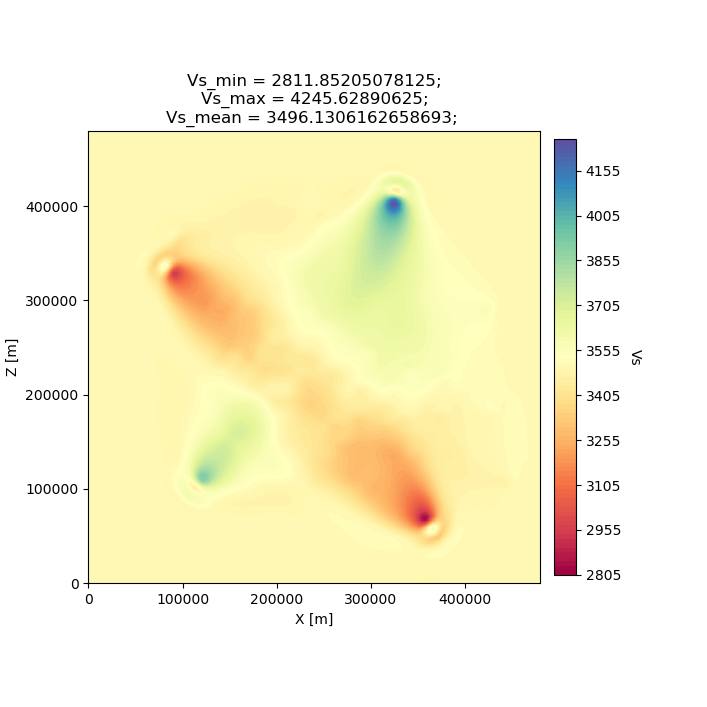

In [19]:
! seisflows plot2d MODEL_02 vs --savefig m_02_vs.png
Image(filename='m_02_vs.png') 

### Re-creating kernels from Tape et al. 2007

The 2D checkerboard model and source-receiver configuration that runs in this example come from the published work of [Tape et al. (2007)](https://academic.oup.com/gji/article/168/3/1105/929373). Here, Tape et al. generate event kernels for a number of individual events ([Figure 9](https://academic.oup.com/view-large/figure/31726687/168-3-1105-fig009.jpeg), shown below). This exercise illustrates how kernel features change for a simple target model (the checkerboard) depending on the chosen source-receiver geometry.   

An attentive reader will notice that the misfit kernel we generated above looks very similar to Panel (h) in the figure below.

Caption from publication: *Construction of a misfit kernel. (a)–(g) Individual event kernels, each constructed via the method shown in Fig. 8 (which shows Event 5). The colour scale for each event kernel is shown beneath (g). (h) The misfit kernel is simply the sum of the 25 event kernels. (i) The source–receiver geometry and target phase‐speed model. There are a total of N= 25 × 132 = 3300 measurements that are used in constructing the misfit kernel (see Section 5).*

#### Choosing an event

The Event ID that generated each kernel is specified in the title of each sub plot (e.g., Panel. (a) corresponds to Event \#1). We can attempt to re-create these kernels by choosing specific event IDs to run Example 2 with. 

To specify the specific event ID, we can use the `--event_id` flag when running Example 2. For this docs page we'll choose Event \#7, which is represented by Panel (g) in the figure above. 

In [13]:
# Run the help message to view the description of the optional arguemnt --event_id
! seisflows examples -h

usage: seisflows examples [-h] [-r [SPECFEM2D_REPO]] [--nsta [NSTA]]
                          [--ntask [NTASK]] [--niter [NITER]]
                          [--event_id [EVENT_ID]]
                          [method] [choice]

Lists out available example problems and allows the user to run example
problems directly from the command line. Some example problems may have pre-
run prompts mainly involving the numerical solver

positional arguments:
  method                Method for running the example problem. If
                        notprovided, simply prints out the list of available
                        example problems. If given as an integer value, will
                        print out the help message for the given example. If
                        'run', will run the example. If 'setup' will simply
                        setup the example working directory but will not
                        execute `seisflows submit`
  choice                If `method` in ['setup', 'run'

In [ ]:
# Run command with open variable to set SPECFEM2D path. Choose event_id==7 and only run 1 iteration
! seisflows examples run 2 -r ${PATH_TO_SPECFEM2D} --event_id 7 --niter 1

#### Comparing kernels

This workflow should run faster than Example \#2 proper, because we are only using 1 event and 1 iteration. In the same vein as above, we can visualize the output gradient to see how well it matches with those published in Tape et al.

In [10]:
%cd ~/sfexamples/example_2a
! ls

/home/bchow/Work/work/seisflows_example/example_2a
logs	parameters.yaml  sflog.txt    specfem2d
output	scratch		 sfstate.txt  specfem2d_workdir


Figure(707.107x707.107)


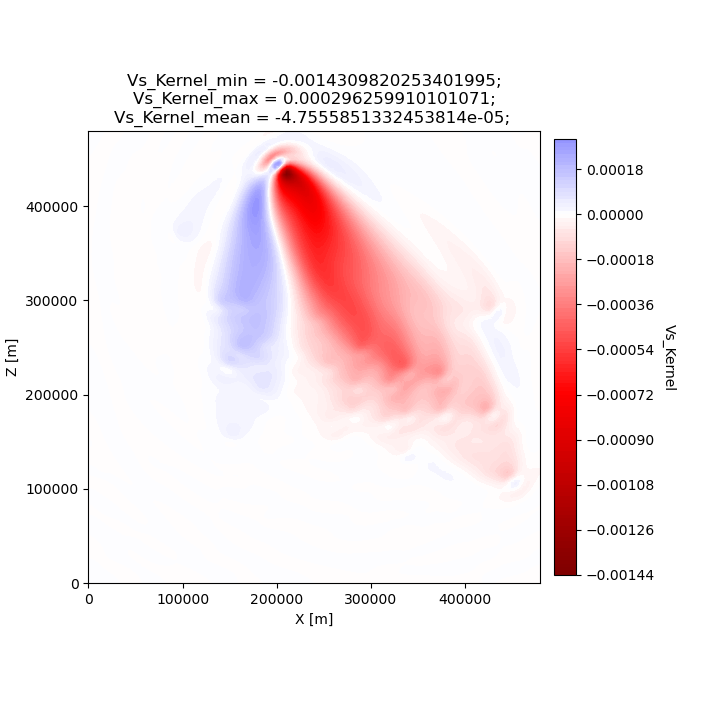

In [4]:
! seisflows plot2d GRADIENT_01 vs_kernel --save g_01_vs.png
Image("g_01_vs.png")

From the above figure we can see that the first order structure of our Vs event kernel is very similar to Panel (g) from Figure 9 of Tape et al. (2007). As mentioned, any differences between the kernel will be due to the differences in the parameters available to us during the inversion. 

Creating all the other kernels shown in Figure 9 of Tape et al. is an exercise left to the reader.

## Example \#3: En-masse Forward Simulations

SeisFlows is not just an inversion tool, it can also be used to simplify workflows to run forward simulations using external numerical solvers. In Example \#3 we use SeisFlows to run en-masse forward simulations. 

### Motivation

Imagine a User who has a velocity model of a specific region (at any scale). This User would like to run a number of forward simulations for **N** events and **S** stations to generate **N** $\times$ **S** synthetic seismograms. These synthetics may be used directly, or compared to observed seismograms to understand how well the regional velocity model characterizes actual Earth structure. 

If **N** is large this effort may require a large number of manual tasks, including the creation of working directories, editing submit calls (if working on a cluster), and book keeping for files generated by the external solver. SeisFlows is here to automate all of these tasks.

### Running the example

In [20]:
# Run the help dialogue to see what occurs in Example 3
! seisflows examples 3

No existing SPECFEM2D repo given, default to: /home/bchow/Work/work/seisflows_example/example_2/specfem2d

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                            @

In [ ]:
# Run command with open variable to set SPECFEM2D path
! seisflows examples run 3 -r ${PATH_TO_SPECFEM2D}

### Understanding example outputs

This example does not produce gradients or updated models, only synthetic seismograms. We can view these seismograms using the `seisflows plotst` command, which is used to quickly plot synthetic seismograms (using ObsPy under the hood). 

In [12]:
%cd ~/sfexamples/example_3
! ls

/home/bchow/Work/work/seisflows_example/example_3
logs	parameters.yaml  sflog.txt    specfem2d
output	scratch		 sfstate.txt  specfem2d_workdir


In this example, we have set the `export_traces` parameter to **True**, which tells SeisFlows to store synthetic waveforms generated during the workflow in the `output/` directory. Under the hood, SeisFlows is copying all synthetic seismograms from the Solver's `scratch/` directory, to a more permanent location.

In [18]:
# The `export_traces` parameter tells SeisFlows to save synthetics after each round of forward simulations
! seisflows par export_traces  

export_traces: True


In [19]:
# Exported traces will be stored in the `output` directory
! ls output

MODEL_INIT  solver


In [23]:
# Synthetics will be stored on a per-event basis, and in the format that the external solver created them
! ls output/solver/
! echo
! ls output/solver/001/syn

001  002  003  004  005  006  007  008	009  010

AA.S000000.BXY.semd  AA.S000009.BXY.semd  AA.S000018.BXY.semd
AA.S000001.BXY.semd  AA.S000010.BXY.semd  AA.S000019.BXY.semd
AA.S000002.BXY.semd  AA.S000011.BXY.semd  AA.S000020.BXY.semd
AA.S000003.BXY.semd  AA.S000012.BXY.semd  AA.S000021.BXY.semd
AA.S000004.BXY.semd  AA.S000013.BXY.semd  AA.S000022.BXY.semd
AA.S000005.BXY.semd  AA.S000014.BXY.semd  AA.S000023.BXY.semd
AA.S000006.BXY.semd  AA.S000015.BXY.semd  AA.S000024.BXY.semd
AA.S000007.BXY.semd  AA.S000016.BXY.semd
AA.S000008.BXY.semd  AA.S000017.BXY.semd


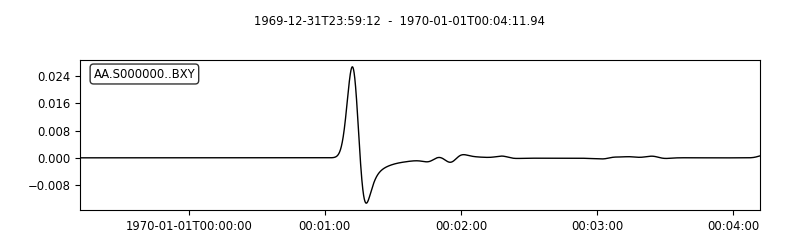

In [24]:
# The `plotst` function allows us to quickly visualize output seismograms
! seisflows plotst output/solver/001/syn/AA.S000000.BXY.semd --save AA.S000000.BXY.semd.png
Image(filename="AA.S000000.BXY.semd.png")

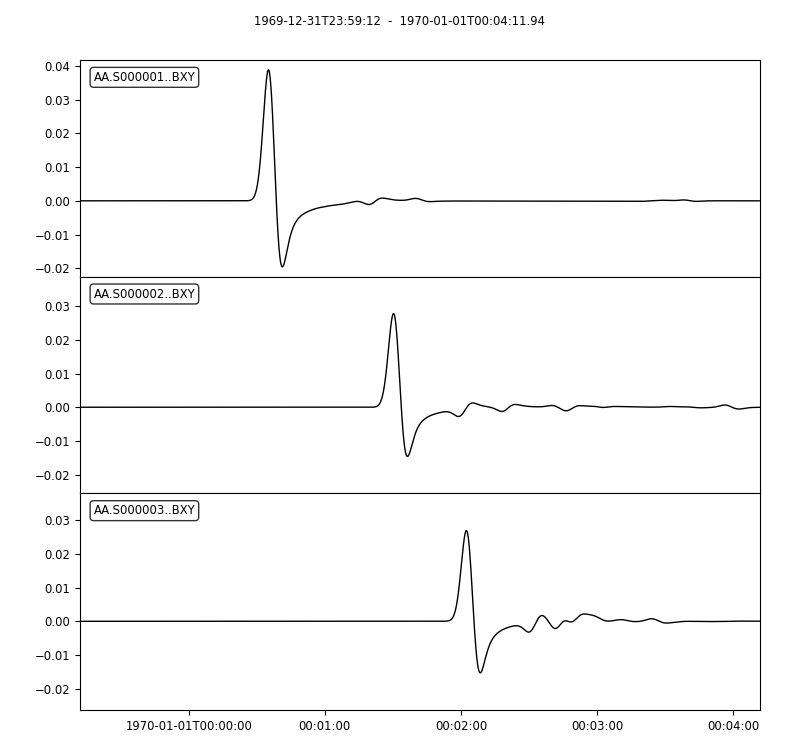

In [25]:
# `plotst` also takes wildcards to plot multiple synthetics in a single figure
! seisflows plotst output/solver/001/syn/AA.S00000[123].BXY.semd --save AA.S000001-3.BXY.semd.png
Image(filename="AA.S000001-3.BXY.semd.png")